***
# Setup

In [1]:
import sys,os
sys.path.append(os.path.expanduser('~/dtreeviz'))

import pandas as pd
import numpy as np
import warnings

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.datasets import make_classification

import xgboost as xgb

from dtreeviz import trees
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree
from dtreeviz.colors import mpl_colors

from wand.image import Image
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

rnd_seed = 42
np.random.seed(rnd_seed)

In [2]:
# model_type = 'sklearn'
model_type = 'xgboost'

In [3]:
inline=True # plot inline or to pdf
output = f'./output_dtreeviz_demo_{model_type}' # output dir
os.makedirs(output, exist_ok=True)

In [4]:
def save_dtreeviz(viz, m_path, fname, tag='', inline=inline, svg=False, png=False, pdf=True):
    if inline:
        display(viz)
    else:
        if not (svg or png or pdf):
            warnings.warn('Not saving anything!')

        os.makedirs(m_path, exist_ok=True)
        full_path = f'{m_path}/{fname}{tag}'

        # svg
        viz.save(f'{full_path}.svg')

        # pdf via svglib
        if pdf:
            renderPDF.drawToFile(svg2rlg(f'{full_path}.svg'), f'{full_path}.pdf')

        # png via wand / ImageMagick
        if png:
            img = Image(filename=f'{full_path}.svg', resolution=500)
            img.format = 'png'
            img.save(filename=f'{full_path}.png')

        if not svg:
            # clean up svg
            os.remove(f'{full_path}.svg')

        # clean up graphviz dot file (no extension)
        os.remove(full_path)

In [5]:
def save_plt(m_path, fname, tag='', inline=inline):
    plt.tight_layout()
    if inline:
        plt.show()
    else:
        os.makedirs(m_path, exist_ok=True)
        plt.savefig(f'{m_path}/{fname}{tag}.pdf')
        plt.close('all')

***
# Generate Random Data

In [6]:
X, y = make_classification(n_samples=int(1e5),
    n_classes=2,
    shuffle=False,
    shift=0.0,
    scale=1.0,
    hypercube=True,
    n_features=15,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_clusters_per_class=5,
    weights=[0.5],
    flip_y=0.05,
    class_sep=0.9,
    random_state=rnd_seed,
)

feat_names = [f'x_{_}' for _ in range(X.shape[1])]

***
# Train Model

In [7]:
if model_type == 'sklearn':
    model = DecisionTreeClassifier(max_depth=3, random_state=rnd_seed+1)
    model.fit(X, y);
    model.feature_names = feat_names
    print(export_text(model, show_weights=True))

In [8]:
if model_type == 'xgboost':
    model = xgb.XGBClassifier(n_estimators=1, max_depth=3, random_state=rnd_seed+1)
    model.fit(X, y);
    model.get_booster().feature_names = feat_names
    print(model.get_booster().get_dump()[0])

0:[x_4<0.0295227729] yes=1,no=2,missing=1
	1:[x_1<-0.395621359] yes=3,no=4,missing=3
		3:[x_2<0.125919729] yes=7,no=8,missing=7
			7:leaf=0.434518665
			8:leaf=-0.336037457
		4:[x_4<-0.983750641] yes=9,no=10,missing=9
			9:leaf=-0.449589133
			10:leaf=-0.269114852
	2:[x_0<0.161112443] yes=5,no=6,missing=5
		5:[x_4<0.485939205] yes=11,no=12,missing=11
			11:leaf=0.067605637
			12:leaf=0.342592031
		6:[x_1<-0.45164454] yes=13,no=14,missing=13
			13:leaf=0.397771627
			14:leaf=-0.00338475383



***
# `dtreeviz` Plots

In [9]:
color_params = {'classes': mpl_colors, 'hist_bar': 'C0', 'legend_edge': None}
for _ in ['axis_label', 'title', 'legend_title', 'text', 'arrow', 'node_label', 'tick_label', 'leaf_label', 'wedge', 'text_wedge']:
    color_params[_] = 'black'
dtv_params_gen = {'colors': color_params, 'fontname': 'Arial'}
dtv_params = {'leaf_plot_type': 'barh',
              'all_axes_spines': False,
              'label_fontsize': 10,
              'colors': dtv_params_gen['colors'],
              'fontname': dtv_params_gen['fontname']
             }

In [10]:
if model_type == 'sklearn':
    shadow_tree = ShadowSKDTree(model, X, y, feat_names, 'y', [0, 1])
    leaf_predictions = None

In [11]:
if model_type == 'xgboost':
    shadow_tree = ShadowXGBDTree(model, 0, X, y, feat_names, 'y', [0, 1])\

    dfp_xgboost = model.get_booster().trees_to_dataframe()
    dfp_xgboost_0 = dfp_xgboost.loc[( (dfp_xgboost['Tree'] == 0) & (dfp_xgboost['Feature'] == 'Leaf') )]
    leaf_predictions = {}
    for _ in dfp_xgboost_0.to_dict('records'):
        leaf_predictions[_['Node']] = _['Gain']

In [12]:
x_example = X[13]
feature_to_look_at_in_detail = 'x_1'
display(pd.DataFrame([{col: value for col,value in zip(feat_names, x_example)}]))

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14
0,2.42538,1.267974,2.303804,-0.636874,-0.121393,-0.205423,-0.502339,0.643387,-0.643301,-2.299074,-0.147235,1.227843,0.708903,-0.043485,0.926461


### Trees

#### Split Hists

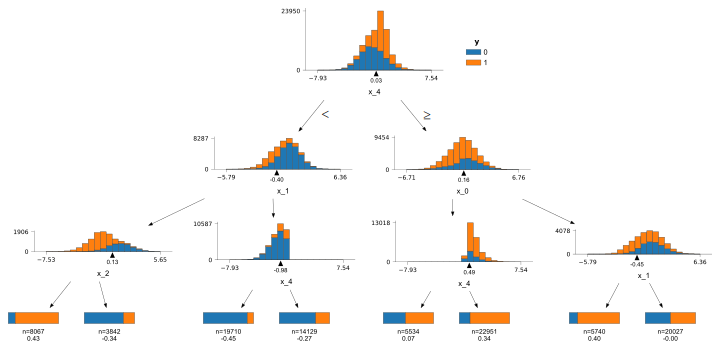

In [13]:
viz = trees.dtreeviz(shadow_tree, leaf_predictions=leaf_predictions, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz')

#### Text

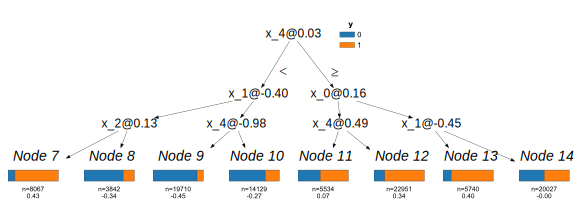

In [14]:
viz = trees.dtreeviz(shadow_tree, leaf_predictions=leaf_predictions, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text')

### Prediction Path

In [15]:
print(trees.explain_prediction_path(shadow_tree, x=x_example, explanation_type='plain_english'))

-0.4 <= x_1 
-0.98 <= x_4  < 0.03



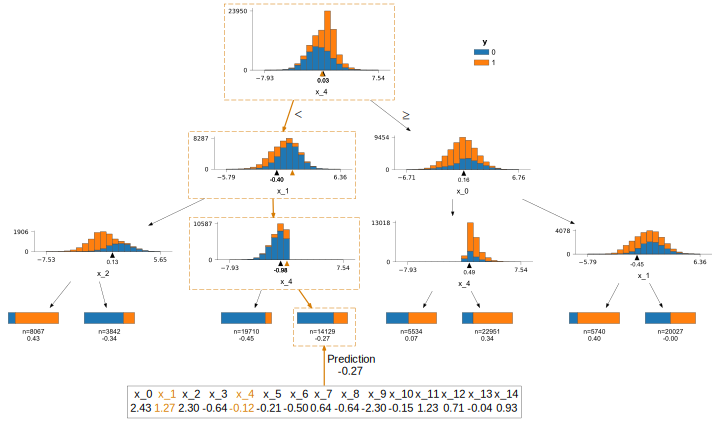

In [16]:
viz = trees.dtreeviz(shadow_tree, leaf_predictions=leaf_predictions, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path')

### Leaf Samples

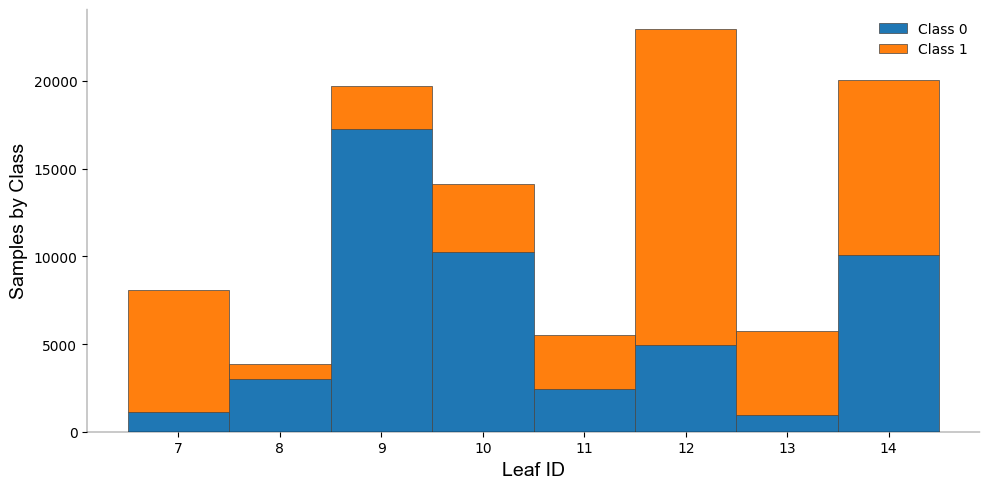

In [17]:
trees.ctreeviz_leaf_samples(shadow_tree, **dtv_params_gen)
save_plt(output, 'ctreeviz_leaf_samples')

### Leaf Criterion

In [18]:
if model_type == 'sklearn':
    trees.viz_leaf_criterion(shadow_tree, display_type='plot', **dtv_params_gen)
    save_plt(output, 'viz_leaf_criterion')

In [19]:
if model_type == 'sklearn':
    trees.viz_leaf_criterion(shadow_tree, display_type='hist', **dtv_params_gen)
    save_plt(output, 'viz_leaf_criterion_hist')

### Splits in Feature Space

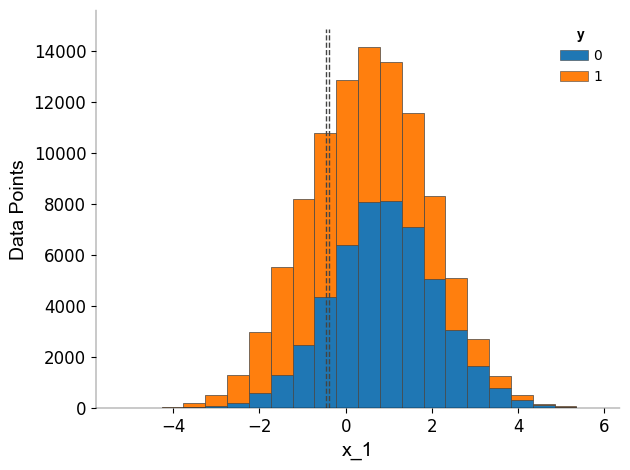

In [20]:
trees.ctreeviz_univar(shadow_tree, feature_name=feature_to_look_at_in_detail, **dtv_params_gen, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar')

### Node Sample

In [21]:
trees.describe_node_sample(shadow_tree, 3)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14
count,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000,11909.000000
mean,-0.658599,-1.304550,-0.599087,-1.011600,-1.420237,-1.196230,1.128833,-0.019605,0.003607,0.005160,-0.008012,0.000855,-0.020112,-0.016424,-0.009553
std,1.570542,0.726805,1.793228,1.278217,1.112108,2.174840,1.120200,1.011154,0.993511,1.001552,1.003930,1.004792,0.990126,1.001222,1.007697
min,-5.876140,-5.788581,-7.534189,-4.770642,-7.617047,-9.372821,-2.597869,-3.865577,-3.759137,-3.974922,-3.728891,-3.792811,-3.463860,-3.629571,-4.075793
25%,-1.652073,-1.681003,-1.817979,-1.903782,-2.078646,-2.487707,0.325498,-0.703863,-0.663199,-0.677442,-0.682054,-0.684906,-0.689256,-0.693967,-0.692191
50%,-0.918918,-1.139181,-0.738770,-1.141256,-1.206418,-1.312453,1.074067,-0.013174,0.003171,0.001145,0.003441,0.000638,-0.019848,-0.016353,-0.010830
75%,0.030627,-0.744226,0.614405,-0.289394,-0.512550,-0.056350,1.887717,0.676175,0.670523,0.686249,0.662057,0.682821,0.640181,0.662104,0.677176
max,6.420748,-0.395725,5.648919,5.357974,0.029094,8.131132,5.488906,4.315949,3.933754,4.152785,4.193026,3.954381,4.015024,3.448112,3.558948
